<a href="https://colab.research.google.com/github/besherh/BigDataManagement/blob/main/SparkNotebooks/clustering_in_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What is clustering
Clustering is an unsupervised learning technique, in short, you are working on data, without having any information about a target attribute or a dependent variable. The general idea of clustering is to find some intrinsic structure in the data, often referred to as groups of similar objects. The algorithm studies the data to identify these patterns or groups such that each member in a group is closer to another member in the group (lower intracluster distance) and farther from another member in a different group (higher inter-cluster distance)


**Examples**


*   Customer Segmentation — Used widely for targeted marketing
*   Recommendation Engines





#Setting up PySpark in Colab
Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.


In [1]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.04 [8,298 kB]
Fetched 36.5 MB in 2s (15.2 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

Now install Spark 3.2.1 with Hadoop 2.7

In [2]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz


--2022-03-20 20:58:25--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  28.6MB/s    in 9.8s    

2022-03-20 20:58:35 (26.6 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



 we just need to unzip that folder.


In [3]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz


There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.


In [4]:
!pip install -q findspark


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.

In [6]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.

In [7]:
import pyspark
import numpy as np
import pandas as pd

#Problem description

The dataset consists of 9K active credit cardholders over 6 months and their transaction and account attributes. The idea is to develop a customer segmentation for marketing strategy.


## Data Preparation

### Removing columns and rows
You previously loaded airline flight data from a CSV file. You're going to develop a model which will predict whether or not a given flight will be delayed.

In this exercise you need to trim those data down by:

1. removing an uninformative column and
2. removing rows which do not have information about whether or not a flight was delayed.

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Customer_Segmants').getOrCreate()

# Read data from CSV file
#you can download it from here:   https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/CC_GENERAL.csv
customer_df=spark.read.csv('/content/CC_GENERAL.csv', header=True, inferSchema=True)

customer_df.show(5)


+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

#Data Schema

In [10]:
customer_df.printSchema()


root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



The attributes that are self intuitive can be divided into three broader categories. Customer Information (Primary Key as CUST_ID), account information (balance, balance frequency, purchases, credit limit, tenure, etc.), and transactions (purchase frequency, payments, cash advance, etc.).


In [11]:
customer_df=customer_df.na.drop()


All attributes under consideration are numerical or discrete numeric, hence we need to convert them into features using a Vector Assembler. A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features. Features here are columns. Since customer id is an identifier that won’t be used for clustering, we first extract the required columns using .columns, pass it as an input to Vector Assembler, and then use the transform() to convert the input columns into a single vector column called a feature.


In [12]:
from pyspark.ml.feature import VectorAssembler
customer_df.columns
assemble=VectorAssembler(inputCols=[
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE'], outputCol='features')
assembled_data=assemble.transform(customer_df)
assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

Now that all columns are transformed into a single feature vector we need to standardize the data to bring them to a comparable scale. E.g. Balance can have a scale from 10–1000 whereas balance frequency has a scale from 0–1 say. Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.


In [13]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)


+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

Now that our data is standardized we can develop the K Means algorithm.
K-means is one of the most commonly used clustering algorithms for grouping data into a predefined number of clusters.


In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.297805743839795
Silhouette Score: 0.2741064742222214
Silhouette Score: 0.29229864278955486
Silhouette Score: 0.2568069809484429
Silhouette Score: 0.29304217697460017
Silhouette Score: 0.2846508945049971
Silhouette Score: 0.28881677419836654
Silhouette Score: 0.30303718489609555


Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is to points in the neighboring clusters thus helping in figuring out clusters that are compact and well-spaced out.


Text(0, 0.5, 'cost')

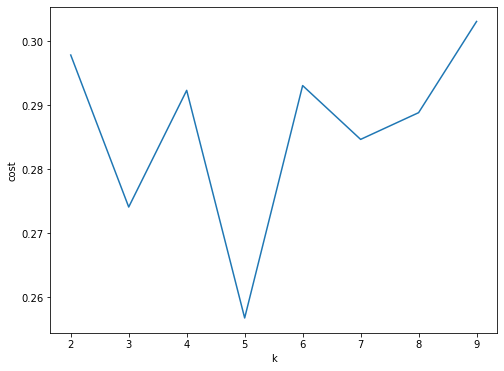

In [16]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')


Highest value when k = 9


In [17]:
final_clustering=KMeans(featuresCol='standardized', k=9)
KMeans_fit=KMeans_algo.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)


In [18]:
#notice the last column [prediction]
clusters_output.show()


+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+----------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|prediction|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------